<a href="https://colab.research.google.com/github/kibali-cell/ML-Projects/blob/main/ExpenseCategorization2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Info:
  Transactions: 385
  Categories:   8
  Category list: Food, Utilities, Transport, Transfers, Bills, Groceries, Income, Alcohol
         Date      Time                    Transaction Type  \
0  2025-04-26  14:38:11                    Merchant Payment   
1  2025-04-26  14:30:32  Customer Payment to Small Business   
2  2025-04-26  03:08:58            Customer Bundle Purchase   
3  2025-04-25  19:56:57                    Merchant Payment   
4  2025-04-25  19:49:20  Customer Payment to Small Business   

                       Recipient   Amount Is Expense   Category  
0       6497271 - Jeremaih kobia  -120.00       True       Food  
1     2547******059 Samwel Kamau  -100.00       True       Food  
2  4093441SAFARICOM DATA BUNDLES   -10.00       True  Utilities  
3      5047120 - KENNEDY MAINA 2  -100.00       True  Transport  
4       2547******216 ANNE NJINO   -70.00       True       Food   

Accuracy: 0.9736842105263158
Classification Report:
               precision    r

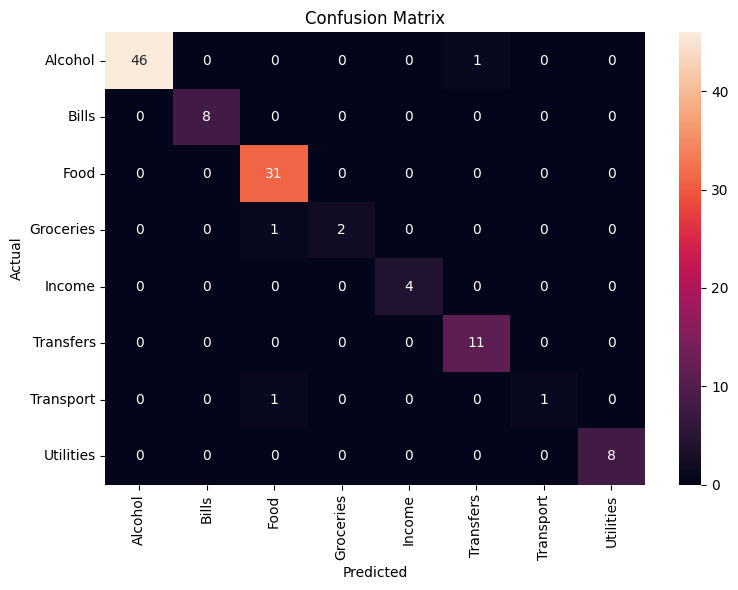

Artifacts saved.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import warnings
import joblib

# Suppress warnings
warnings.filterwarnings('ignore')

# 1) Loading and inspecting the dataset
df = pd.read_csv('mpesa_transactions.csv')
print("Dataset Info:")
print(f"  Transactions: {len(df)}")
print(f"  Categories:   {df['Category'].nunique()}")
print("  Category list:", ", ".join(df['Category'].dropna().astype(str).unique()))
print(df.head(), "\n")

# 2) Data Preprocessing
# — parse datetime
df['DateTime']  = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Hour']      = df['DateTime'].dt.hour
df['Month']     = df['DateTime'].dt.month

# — clean Amount, convert to numeric
df['Amount'] = (
    df['Amount']
      .astype(str)
      .str.replace(r'[^\d\.-]', '', regex=True)
)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# — derive Is Expense from Amount
df['Is Expense'] = (df['Amount'] < 0).astype(int)

# — drop rows with no category
df = df[df['Category'].notna()].copy()

# 3) Feature extraction
def extract_recipient_type(text):
    text = str(text).lower()
    for k in ['payment','transfer','merchant','bill','bundle']:
        if k in text:
            return k
    return "other"

df['RecipientType'] = df['Transaction Type'].apply(extract_recipient_type)

def extract_name(text):
    text = str(text)
    if '-' in text:
        return text.split('-',1)[1].strip()
    m = re.search(r'\d+\s+(.*)', text)
    return m.group(1).strip() if m else text

df['RecipientName'] = df['Recipient'].apply(extract_name)

# 4) Encode target
lbl = LabelEncoder()
df['CategoryEnc'] = lbl.fit_transform(df['Category'])

# 5) One-hot & text vectorization
df_ohe = pd.get_dummies(df, columns=['Transaction Type','RecipientType'])
vec    = CountVectorizer(max_features=50, stop_words='english')
txt    = vec.fit_transform(df['RecipientName'].fillna(''))
df_txt = pd.DataFrame(txt.toarray(),
                      columns=vec.get_feature_names_out(),
                      index=df_ohe.index)

# 6) Assemble feature matrix
drop = ['Date','Time','Recipient','RecipientName','Category','DateTime','CategoryEnc']
X = pd.concat([df_ohe.drop(columns=drop), df_txt], axis=1)
y = df['CategoryEnc']

# — drop any leftover object columns
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    print("Dropping object columns:", obj_cols)
    X = X.select_dtypes(exclude=['object'])

# 7) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 8) (Optional) hyperparameter tuning
# params = {'n_estimators':[50,100,200], 'max_depth':[None,10,20]}
# gs = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5)
# gs.fit(X_train, y_train)
# rf = gs.best_estimator_

# 9) Fit final model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 10) Evaluate
y_pred = rf.predict(X_test)
y_true = lbl.inverse_transform(y_test)
y_pr   = lbl.inverse_transform(y_pred)
print("Accuracy:", accuracy_score(y_true, y_pr))
print("Classification Report:\n", classification_report(y_true, y_pr))

cm = confusion_matrix(y_true, y_pr, labels=lbl.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=lbl.classes_, yticklabels=lbl.classes_)
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# 11) Prediction helper
def predict_category(txn_type, recipient, amount,
                     is_expense=None, hour=12, dow=0, month=None):
    if is_expense is None:
        is_expense = amount < 0
    rec_type = extract_recipient_type(txn_type)
    rec_name = extract_name(recipient)
    data = {
        'Amount':[amount],
        'Is Expense':[int(is_expense)],
        'DayOfWeek':[dow],
        'Hour':[hour],
        'Month': [month or df['Month'].mode()[0]],
        'Transaction Type':[txn_type],
        'RecipientType':[rec_type]
    }
    d = pd.DataFrame(data)
    d_ohe = pd.get_dummies(d, columns=['Transaction Type','RecipientType'])
    for c in X.columns:
        d_ohe[c] = d_ohe.get(c,0)
    d_ohe = d_ohe[X.columns]
    # text features
    v = vec.transform([rec_name])
    for i,feat in enumerate(vec.get_feature_names_out()):
        d_ohe[feat] = v.toarray()[0][i]
    pe    = rf.predict(d_ohe)[0]
    probs = rf.predict_proba(d_ohe)[0]
    return lbl.inverse_transform([pe])[0], dict(zip(lbl.inverse_transform(rf.classes_),probs))

# 12) Save model + encoders
joblib.dump({
    'model':rf,
    'label_enc':lbl,
    'vectorizer':vec,
    'features':X.columns.tolist()
}, 'mpesa_classifier_artifacts.pkl')
print("Artifacts saved.")
